In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [2]:
# set plot style
plt.style.use('ggplot')

In [3]:
# import data
pp_data = pd.read_csv("../data/pp_data_2018_processed.csv")
pp_duration = pd.read_csv("../data/pp_duration_2018_processed.csv")

In [4]:
pp_data.head()

,age,sex,height_in,start_weight,end_weight,weight_diff,score,num_comments,month,dayofweek,NSFW,num_posts
0,22.0,0,75.0,290.0,185.0,105.0,246.0,10.0,1.0,5.0,0.0,1.0
1,27.0,1,70.0,355.0,340.0,15.0,576.0,31.0,1.0,5.0,0.0,12.0
2,23.0,1,60.0,260.0,218.0,42.0,210.0,5.0,1.0,5.0,0.0,1.0
3,24.0,1,63.0,160.0,135.0,25.0,1.0,1.0,1.0,5.0,0.0,1.0
4,48.0,1,66.0,326.0,180.0,146.0,3163.0,144.0,1.0,5.0,0.0,15.0


In [5]:
pp_duration.head()

,age,sex,height_in,start_weight,end_weight,weight_diff,score,num_comments,month,dayofweek,NSFW,num_posts,period_months,rate,norm_rate
0,22.0,0,75.0,290.0,185.0,105.0,246.0,10.0,1.0,5.0,0.0,1.0,24.0,4.375000,0.015086
1,27.0,1,70.0,355.0,340.0,15.0,576.0,31.0,1.0,5.0,0.0,12.0,1.0,15.000000,0.042254
2,23.0,1,60.0,260.0,218.0,42.0,210.0,5.0,1.0,5.0,0.0,1.0,12.0,3.500000,0.013462
3,24.0,1,63.0,160.0,135.0,25.0,1.0,1.0,1.0,5.0,0.0,1.0,6.0,4.166667,0.026042
4,48.0,1,66.0,326.0,180.0,146.0,3163.0,144.0,1.0,5.0,0.0,15.0,101.0,1.445545,0.004434


### Functions for regression analysis

In [6]:
# simple linear regression
def linear_regression(y, df, exclude):
    """Generates a simple linear regression model for the provided dependent variable and each independent variable 
    in the provided dataframe, but not included in the exclude list.  Prints the summary of each model and returns a 
    dataframe containing model information. 
    
    Arguments:
    y -- column name of the dependent variable; provide a string
    df -- Pandas dataframe that contains the data for the dependent and independent variables; provide a df
    exclude --  column name(s) to be excluded from the analysis; provide a list of strings or an empty list if
        there are no columns to exclude
        
    Returns:
    results_df -- Pandas dataframe that contains information about each model generated including the F-statistic, F-statistic 
    p-value, t-test, t-test p-value, and R-squared value.
    """
    exclude_cols = []
    results = {}
    exclude_cols.append(y)
    exclude_cols.extend(exclude)
    print('y =', y)
    print("excluded features:", exclude_cols)
    print("df shape:", df.shape)
    features = [col for col in df.columns if col not in exclude_cols]
    for f in features:
        str1 = "{0} ~ {1}".format(y, f)
        reg_model = sm.OLS.from_formula(str1, df).fit()
        results[f] = [round(reg_model.rsquared, 3), round(reg_model.fvalue, 1), round(reg_model.f_pvalue, 4), 
                     round(reg_model.tvalues[1], 2), round(reg_model.pvalues[1], 4)]
        print('X =', f.upper())
        print(reg_model.summary())
        print('')  
    results_df = pd.DataFrame.from_dict(results, columns=["R-sqr", "F-statistic", "F-stat p-value", 't-test',
                                                          't-test p-value'], orient='index')
    return results_df.sort_values("R-sqr", ascending=False)

In [7]:
# diagnostic plots for a simple linear regression
def lin_regr_diagnostic_plots(y, x, df):
    """Generates diagnostic plots used to evaluate a simple linear regression model. The plots include a scatter plot 
    of the independent variable vs the dependent variable to evaluate linearity, a scatter plot of the standardized
    residuals vs fitted values to evaluate error variance, and a probability plot to evaluate error normality. 
    
    Arguments:
    y -- column name of the dependent variable; provide a string
    x -- column name of the independent variable; provide a string
    df -- Pandas dataframe that contains the data for the dependent and independent variables; provide a df
        
    Returns:
    None 
    """
    str1 = "{0} ~ {1}".format(y, x)
    reg_model = sm.OLS.from_formula(str1, df).fit()
    fit_values = pd.Series(reg_model.fittedvalues, name="fitted_values")
    residuals = pd.Series(reg_model.resid, name="residuals")
    norm_residuals = pd.Series(reg_model.get_influence().resid_studentized_internal, name="Standardized Residual")
                                                              
    fig = plt.figure(constrained_layout=True, figsize=(8,8))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title("Regression plot")
    sns.regplot(x, y, df, line_kws={'color':'r'}, ci=None, ax=ax1)
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.set_title("Standardized residuals vs Fit plot")
    sns.regplot(fit_values, norm_residuals, line_kws={'color':'r'}, ci=None, ax=ax2)
    ax3 = fig.add_subplot(gs[0:, -1])
    sp.stats.probplot(norm_residuals, plot=ax3, fit=True)
    fig.suptitle('y = {}, x = {}'.format(y, x, df), fontsize=14)
    
    return fig

In [8]:
# These functions implement the "best subsets" regression procedure

def process_subset(y, feature_set, df):
    """Generates a linear regression model and returns the number of independent variables it contains, the 
    names of the independent variables, the model, and the model's RSS value, R-squared value, and R-squared-adjusted
    value.
    """
    str1 = str(y) + ' ~ ' + ' + '.join(list(feature_set))
    model = sm.OLS.from_formula(str1, df)
    regr = model.fit()
    RSS = ((regr.predict(df[list(feature_set)]) - df[y]) ** 2).sum()
    R_squared = regr.rsquared
    R_squared_adj = regr.rsquared_adj
    return {"num_predictors": len(feature_set), "predictors": feature_set, "RSS": RSS, "rsquared": R_squared, "rsquared_adj": R_squared_adj, "model":regr}

def get_best(y, df, features, k):
    """Generates all possible combinations of independent variables, generates linear regression models using the
    variable combinations and returns those with the highest R-squared-adjusted values.
    """
    results = []
    for combo in itertools.combinations(features, k):
        #print("combo:", combo)
        inv_results = process_subset(y, combo, df)
        #print("results:", inv_results["rsquared_adj"])
        results.append(inv_results)
    models = pd.DataFrame(results)
    best_model = models.nlargest(2, "rsquared_adj")
    #print("Best model", best_model)
    return best_model

def subset_linear_regression(y, df, exclude):
    """Generates regression models using all possible combinations of independent variables, then chooses the models 
    with the highest R-squared-adj values. 
    
    Arguments:
    y -- column name of the dependent variable; provide a string
    df -- Pandas dataframe that contains the data for the dependent and independent variables; provide a df
    exclude --  column name(s) to be excluded from the analysis; provide a list of strings or an empty list if
        there are no columns to exclude
        
    Returns:
    models -- Pandas dataframe that contains information about the two (or one) model(s) with the highest R-squared adj
    value from the independent variable combinations.  For example, if there are 4 independent variables, the function 
    will return the two models with the highest R-squared-adj. value if one, two, and three independent variables are 
    included as well as the single model that contains four predictors. The returned information includes the number of 
    independent variables, the names of the independent variables, the model, and the model's RSS value, 
    R-squared value, and R-squared-adjusted value.
    """
    models = pd.DataFrame(columns=["num_predictors", "predictors", "RSS", "rsquared", "rsquared_adj", "model"])
    exclude_cols = []
    exclude_cols.append(y)
    exclude_cols.extend(exclude)
    features = [f for f in df.columns if f not in exclude_cols]
    for i in range(1, len(features)):
        #print("i:", i)
        models = pd.concat([models, get_best(y, df, features, i)], sort=True)
    return models

In [9]:
# These functions implement the "forward stepwise" regression procedure

def process_subset_ttest(y, feature_set, df):
    """Generates a linear regression model and returns the t-test p-values for all the included independent variables.
    """
    str1 = str(y) + ' ~ ' + ' + '.join(list(feature_set))
    model = sm.OLS.from_formula(str1, df)
    regr = model.fit()
    summary = regr.summary().tables[1]
    pvals = regr.pvalues
    results_series = pd.Series(pvals)
    #print(results_series)
    return results_series

def process_best_model(y, feature_set, df):
    """Generates a linear regression model and returns the number of independent variables it contains, the 
    names of the independent variables, the model, and the model's RSS value, R-squared value, and R-squared-adjusted
    value.
    """
    str1 = str(y) + ' ~ ' + ' + '.join(list(feature_set))
    model = sm.OLS.from_formula(str1, df)
    regr = model.fit()
    RSS = ((regr.predict(df[list(feature_set)]) - df[y]) ** 2).sum()
    R_squared = regr.rsquared
    R_squared_adj = regr.rsquared_adj
    return {"num_predictors": len(feature_set), "predictors": feature_set, "RSS": RSS, "rsquared": R_squared, "rsquared_adj": R_squared_adj, "model":regr}   

def forward_stepwise(y, predictors, y_and_exclude, df):
    """Takes the existing regression model and adds each remaining independent variable to it one at a time.  Compares
    the t-test p-values of new models and identifies the lowest t-test p-value.  If all variables are below the 
    0.15 signficance level, the included predictors are returned.  If the t-test p-values any of the previously 
    included variables now fall below the 0.15 level, they are removed and the remaining predictors are returned.
    """
    remaining_predictors = [p for p in df.columns if p not in predictors and p not in y_and_exclude]
    #print("remaining predictors: ", remaining_predictors)
    results = []
    for p in remaining_predictors:
        #print("p:", p)
        results.append(process_subset_ttest(y, (predictors + [p]), df)) # results is a list of pd Series
    #print("results:", results)
    low_pvalue = 0.15
    index_of_best_series = False
    new_predictors = []
    count = 0
    for i in range(len(results)):
        #print("i", i)
        #print("last value:", results[i][-1].item())
        current = results[i][-1].item()
        if current < 0.15:
            count =+ 1
            if current < low_pvalue:
                low_pvalue = current
                index_best_series = i
    if count == 0:
        for index, value in results[0][:-1].iteritems():
            #print("count = 0, index:", index, "value:", value)
            if index != "Intercept":
                new_predictors.append(index) 
        return(new_predictors)        
    for index, value in results[index_best_series].iteritems():
        #print("index:", index, "value:", value)
        if index != "Intercept":
            if value < 0.15:
                new_predictors.append(index)
    #print("new_predictors:", new_predictors)
    return(new_predictors) 

def stepwise_linear_regression(y, df, exclude):
    """First, individually evaluates independent variables in a linear regression model. The independent variable with 
    the lowest t-test p-value becomes the starting model.  Then the remainder of the independent variables are 
    individually added to the starting model.  If none have a significant t-test p-value then the process ends, but
    if one or many do, the one with the lowest t-test p-value is retained and a new starting model is established (after 
    it is determined that the original independent variable still has a significant t-test p-value).  This process is 
    repeated until no newly added independent variablies have a significant t-test p-value.  The best model from each 
    step is returned. 
    
    Arguments:
    y -- column name of the dependent variable; provide a string
    df -- Pandas dataframe that contains the data for the dependent and independent variables; provide a df
    exclude --  column name(s) to be excluded from the analysis; provide a list of strings or an empty list if
        there are no columns to exclude
        
    Returns:
    models_step -- Pandas dataframe that contains information about best model identified at each step of the process.
    The returned information includes the number of independent variables, the names of the independent variables, the 
    model, and the model's RSS value, R-squared value, and R-squared-adjusted value.
    """
    y_and_exclude = []
    y_and_exclude.append(y)
    y_and_exclude.extend(exclude)
    dep_var = df.shape[1] - len(y_and_exclude)
    #print(dep_var)
    old_predictors = []
    step = 0
    best_models = []
    new_predictors = forward_stepwise(y, old_predictors, y_and_exclude, df)
    best_predictors = [new_predictors]
    #print("1st comparision:", old_predictors, new_predictors)
    while old_predictors != new_predictors:
        step += 1
        #print("step", step)
        old_predictors = new_predictors
        #print('old_predictors:', old_predictors)
        if len(old_predictors) == dep_var:
            break
        new_predictors = forward_stepwise(y, old_predictors, y_and_exclude, df)
        #print('new_predictors:', new_predictors)
        best_predictors.append(new_predictors)
    #print("best_predictors:", best_predictors)    
    for predictor_list in best_predictors[:-1]:
        #print("predictor_list:", predictor_list)
        if predictor_list[-1] == None:
            pass
        else:
            best_models.append(process_best_model(y, predictor_list, df))    
    models_step = pd.DataFrame(best_models)
    return models_step

## Regression analysis

### Dependent variable = score

Exclude num_comments since it is another descriptor of post populatrity

Use both the pp_data and pp_duration datasets

In [10]:
# simple linear regression using pp_data
score = linear_regression("score", pp_data, ['num_comments'])

y = score
excluded features: ['score', 'num_comments']
df shape: (20065, 12)
X = AGE
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     144.5
Date:                Thu, 19 Sep 2019   Prob (F-statistic):           3.63e-33
Time:                        12:37:47   Log-Likelihood:            -1.6974e+05
No. Observations:               20065   AIC:                         3.395e+05
Df Residuals:                   20063   BIC:                         3.395e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     932.7
Date:                Thu, 19 Sep 2019   Prob (F-statistic):          2.93e-200
Time:                        12:37:48   Log-Likelihood:            -1.6936e+05
No. Observations:               20065   AIC:                         3.387e+05
Df Residuals:                   20063   BIC:                         3.387e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     218.7721     11.274     19.405      

In [11]:
score

,R-sqr,F-statistic,F-stat p-value,t-test,t-test p-value
weight_diff,0.044,932.7,0.0000,30.54,0.0000
num_posts,0.022,461.8,0.0000,21.49,0.0000
sex,0.019,391.3,0.0000,19.78,0.0000
start_weight,0.019,388.4,0.0000,19.71,0.0000
age,0.007,144.5,0.0000,12.02,0.0000
height_in,0.007,135.4,0.0000,-11.64,0.0000
NSFW,0.002,31.4,0.0000,-5.60,0.0000
end_weight,0.000,0.4,0.5120,0.66,0.5120
month,0.000,6.6,0.0103,2.57,0.0103
dayofweek,0.000,0.0,0.8972,0.13,0.8972


None of the variables look like very good predictors for the score of a post even though most have significant p-values...only month and dayofweek are not significant. 

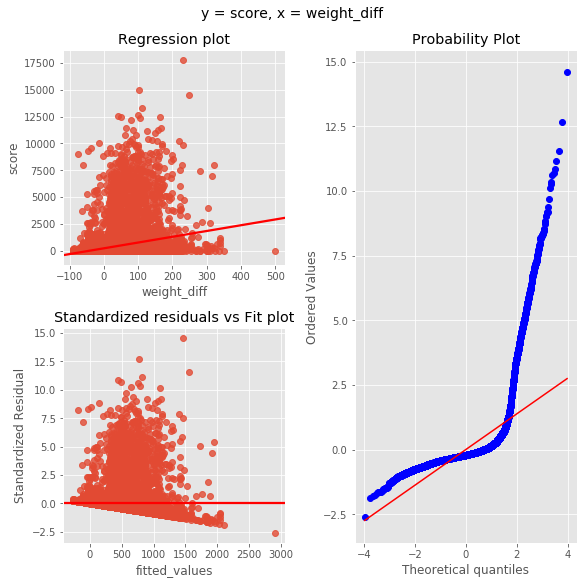

In [12]:
# diagnostic plots for the best feature in pp_data
fig = lin_regr_diagnostic_plots("score", "weight_diff", pp_data)

Looks like the model created with score predicting weight_diff violates most of the LINE assumptions.  Not a good feature. 

In [13]:
# simple linear regression using pp_duration
score_dur = linear_regression("score", pp_duration, ['norm_rate', 'num_comments'])

y = score
excluded features: ['score', 'norm_rate', 'num_comments']
df shape: (12517, 15)
X = AGE
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     76.81
Date:                Thu, 19 Sep 2019   Prob (F-statistic):           2.12e-18
Time:                        12:37:58   Log-Likelihood:            -1.0560e+05
No. Observations:               12517   AIC:                         2.112e+05
Df Residuals:                   12515   BIC:                         2.112e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2623
Date:                Thu, 19 Sep 2019   Prob (F-statistic):              0.609
Time:                        12:37:59   Log-Likelihood:            -1.0564e+05
No. Observations:               12517   AIC:                         2.113e+05
Df Residuals:                   12515   BIC:                         2.113e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    451.0859     22.807     19.779      0.0

In [14]:
score_dur

,R-sqr,F-statistic,F-stat p-value,t-test,t-test p-value
weight_diff,0.047,620.7,0.0000,24.91,0.0000
sex,0.022,279.3,0.0000,16.71,0.0000
start_weight,0.016,204.3,0.0000,14.29,0.0000
num_posts,0.009,114.9,0.0000,10.72,0.0000
height_in,0.008,102.9,0.0000,-10.14,0.0000
age,0.006,76.8,0.0000,8.76,0.0000
rate,0.005,59.5,0.0000,7.71,0.0000
period_months,0.004,52.5,0.0000,7.25,0.0000
NSFW,0.002,21.4,0.0000,-4.62,0.0000
end_weight,0.001,7.3,0.0069,-2.70,0.0069


Again, none of the variables look like very good predictors for the score of a post even though most have significant p-values...only month and dayofweek are not significant. 

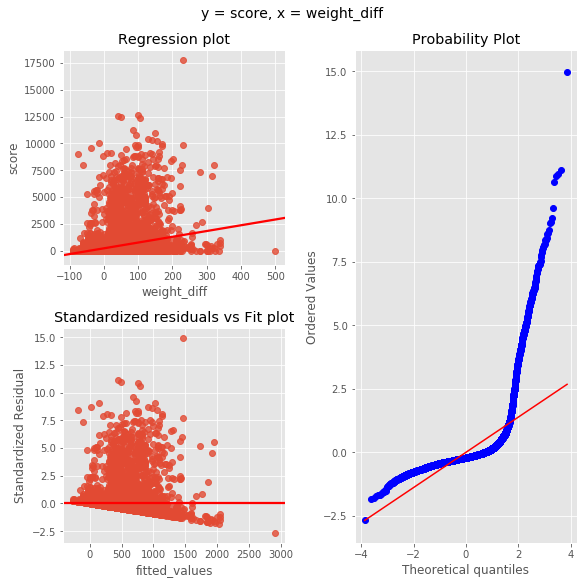

In [15]:
# diagnostic plots for the best feature in pp_duration
fig = lin_regr_diagnostic_plots("score", "weight_diff", pp_duration)

Again, looks like the model created with score predicting weight_diff using the pp_duration dataset violates most of the LINE assumptions.  Not a good feature. 

In [16]:
# forward stepwise multiple linear regression for pp_data
# remove features that were not significant in the simple linear regression
score_step = stepwise_linear_regression("score", pp_data, ['num_comments', 'end_weight', 'dayofweek'])

In [17]:
score_step

,num_predictors,predictors,RSS,rsquared,rsquared_adj,model
0,1,[weight_diff],2.519795e+10,0.044422,0.044374,<statsmodels.regression.linear_model.Regressio...
1,2,"[weight_diff, sex]",2.460939e+10,0.066742,0.066649,<statsmodels.regression.linear_model.Regressio...
2,3,"[weight_diff, sex, num_posts]",2.425364e+10,0.080233,0.080095,<statsmodels.regression.linear_model.Regressio...
3,4,"[weight_diff, sex, num_posts, NSFW]",2.421245e+10,0.081795,0.081612,<statsmodels.regression.linear_model.Regressio...
4,5,"[weight_diff, sex, num_posts, NSFW, age]",2.418058e+10,0.083003,0.082775,<statsmodels.regression.linear_model.Regressio...


In [18]:
# best subsets multiple linear regression for pp_data
# remove features that were not significant in the simple linear regression
score_subset = subset_linear_regression("score", pp_data, ['num_comments', 'end_weight', 'dayofweek'])

In [19]:
score_subset

,RSS,model,num_predictors,predictors,rsquared,rsquared_adj
4,2.519795e+10,<statsmodels.regression.linear_model.Regressio...,1,"(weight_diff,)",0.044422,0.044374
7,2.577603e+10,<statsmodels.regression.linear_model.Regressio...,1,"(num_posts,)",0.022499,0.022451
9,2.460939e+10,<statsmodels.regression.linear_model.Regressio...,2,"(sex, weight_diff)",0.066742,0.066649
24,2.476112e+10,<statsmodels.regression.linear_model.Regressio...,2,"(weight_diff, num_posts)",0.060988,0.060894
32,2.425364e+10,<statsmodels.regression.linear_model.Regressio...,3,"(sex, weight_diff, num_posts)",0.080233,0.080095
42,2.450861e+10,<statsmodels.regression.linear_model.Regressio...,3,"(height_in, weight_diff, num_posts)",0.070564,0.070425
53,2.421245e+10,<statsmodels.regression.linear_model.Regressio...,4,"(sex, weight_diff, NSFW, num_posts)",0.081795,0.081612
11,2.422156e+10,<statsmodels.regression.linear_model.Regressio...,4,"(age, sex, weight_diff, num_posts)",0.081449,0.081266
18,2.418058e+10,<statsmodels.regression.linear_model.Regressio...,5,"(age, sex, weight_diff, NSFW, num_posts)",0.083003,0.082775
49,2.420987e+10,<statsmodels.regression.linear_model.Regressio...,5,"(sex, weight_diff, month, NSFW, num_posts)",0.081893,0.081664


Trying multiple linear regression with pp_data dataset to understand the score variable:  Weight_diff alone gives a R squared value of 0.04 and that can be doubled to 0.83 by including age, sex, weight_diff, NSFW, and num_posts.  However that model still doesn't explain the variation in the score variable very well and it is complex. 

In [20]:
# forward stepwise multiple linear regression for pp_duration
# remove features that were not significant in the simple linear regression
score_dur_step = stepwise_linear_regression("score", pp_duration, ['num_comments', 'month', 'dayofweek'])

In [21]:
score_dur_step

,num_predictors,predictors,RSS,rsquared,rsquared_adj,model
0,1,[weight_diff],1.495519e+10,0.047256,0.047180,<statsmodels.regression.linear_model.Regressio...
1,2,"[weight_diff, sex]",1.456082e+10,0.072380,0.072232,<statsmodels.regression.linear_model.Regressio...
2,3,"[weight_diff, sex, norm_rate]",1.448643e+10,0.077120,0.076898,<statsmodels.regression.linear_model.Regressio...
3,4,"[weight_diff, sex, norm_rate, num_posts]",1.443006e+10,0.080711,0.080417,<statsmodels.regression.linear_model.Regressio...
4,5,"[weight_diff, sex, norm_rate, num_posts, NSFW]",1.440228e+10,0.082481,0.082114,<statsmodels.regression.linear_model.Regressio...
5,6,"[weight_diff, sex, norm_rate, num_posts, NSFW,...",1.438198e+10,0.083773,0.083334,<statsmodels.regression.linear_model.Regressio...
6,7,"[weight_diff, sex, norm_rate, num_posts, NSFW,...",1.434338e+10,0.086232,0.085721,<statsmodels.regression.linear_model.Regressio...
7,8,"[weight_diff, sex, norm_rate, num_posts, NSFW,...",1.434338e+10,0.086232,0.085721,<statsmodels.regression.linear_model.Regressio...
8,9,"[weight_diff, sex, norm_rate, num_posts, NSFW,...",1.432509e+10,0.087398,0.086814,<statsmodels.regression.linear_model.Regressio...
9,10,"[weight_diff, sex, norm_rate, num_posts, NSFW,...",1.431696e+10,0.087916,0.087260,<statsmodels.regression.linear_model.Regressio...


In [22]:
# best subsets multiple linear regression for pp_duration
# remove features that were not significant in the simple linear regression
score_dur_subset = subset_linear_regression("score", pp_duration, ['num_comments', 'month', 'dayofweek'])

In [23]:
score_dur_subset

,RSS,model,num_predictors,predictors,rsquared,rsquared_adj
5,1.495519e+10,<statsmodels.regression.linear_model.Regressio...,1,"(weight_diff,)",0.047256,0.047180
1,1.535436e+10,<statsmodels.regression.linear_model.Regressio...,1,"(sex,)",0.021826,0.021748
13,1.456082e+10,<statsmodels.regression.linear_model.Regressio...,2,"(sex, weight_diff)",0.072380,0.072232
21,1.474790e+10,<statsmodels.regression.linear_model.Regressio...,2,"(height_in, weight_diff)",0.060462,0.060312
70,1.448643e+10,<statsmodels.regression.linear_model.Regressio...,3,"(sex, weight_diff, norm_rate)",0.077120,0.076898
67,1.451057e+10,<statsmodels.regression.linear_model.Regressio...,3,"(sex, weight_diff, num_posts)",0.075581,0.075360
190,1.443006e+10,<statsmodels.regression.linear_model.Regressio...,4,"(sex, weight_diff, num_posts, norm_rate)",0.080711,0.080417
193,1.445774e+10,<statsmodels.regression.linear_model.Regressio...,4,"(sex, weight_diff, rate, norm_rate)",0.078947,0.078653
323,1.440228e+10,<statsmodels.regression.linear_model.Regressio...,5,"(sex, weight_diff, NSFW, num_posts, norm_rate)",0.082481,0.082114
329,1.440953e+10,<statsmodels.regression.linear_model.Regressio...,5,"(sex, weight_diff, num_posts, rate, norm_rate)",0.082019,0.081652


Trying multiple linear regression with pp_duration dataset to understand the score variable:  Weight_diff alone gives a R squared value of 0.047 and that can be almost doubled to 0.87 by including 8 variablies.  However that model still doesn't explain the variation in the score variable very well and it is complex. 